In [1]:
import pandas as pd
import numpy as np

from imageio import imread

import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img,img_to_array

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.resnet50 import ResNet50
from keras import applications
get_ipython().magic('matplotlib inline')
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity

In [2]:
from datetime import datetime
from hummingbird.ml import convert
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import coremltools as ct
import pickle as pkl

In [3]:
train1=pd.read_csv("pet_image_web2.csv")
train1=train1.iloc[:,[2,3,4,5,6,7]]
train1.head()

,age,image,web,name,size,sex
0,Senior,https://s3.amazonaws.com/filestore.rescuegroup...,https://www.aspca.org/adopt-pet/adoptable-dogs...,Candie,NaN,Female (spayed)
1,Senior,https://s3.amazonaws.com/filestore.rescuegroup...,https://www.aspca.org/adopt-pet/adoptable-dogs...,PRINCE,Large,Male
2,Senior,https://s3.amazonaws.com/filestore.rescuegroup...,https://www.aspca.org/adopt-pet/adoptable-dogs...,SOPHIE,Large,Female
3,Senior,https://s3.amazonaws.com/filestore.rescuegroup...,https://www.aspca.org/adopt-pet/adoptable-dogs...,CANELO,Large,Male
4,Adult,https://s3.amazonaws.com/filestore.rescuegroup...,https://www.aspca.org/adopt-pet/adoptable-dogs...,ZAC,NaN,Male


In [4]:
train1['age_new']=train1.age
train1.age_new.value_counts()
train1.age_new[train1['age']=='Senior']=3
train1.age_new[train1['age']=='Adult']=2
train1.age_new[train1['age']=='Young']=1
train1.age_new[train1['age']=='Baby']=0

In [5]:
print(train1.shape)
train1.head(2)

(19203, 7)


,age,image,web,name,size,sex,age_new
0,Senior,https://s3.amazonaws.com/filestore.rescuegroup...,https://www.aspca.org/adopt-pet/adoptable-dogs...,Candie,NaN,Female (spayed),3
1,Senior,https://s3.amazonaws.com/filestore.rescuegroup...,https://www.aspca.org/adopt-pet/adoptable-dogs...,PRINCE,Large,Male,3


### loading VGG16 model weights

In [6]:
vgg_model = VGG16(weights='imagenet') #, include_top=False)
# remove the last layers in order to get features instead of predictions
feat_extractor = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer("fc2").output)

# print the layers of the CNN
feat_extractor.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [7]:
imgs_model_width, imgs_model_height = 224, 224

##### get the images paths

##### feed one image into the CNN
First we observe what output we get when putting one image into the CNN.

The following steps are:

- loading the image
- preparing the image to feed it into the CNN
- get the CNN output which will correspond to the image features

In [8]:
#!pip3 install pillow
#!pip3 install requests
import sys
import requests
from PIL import Image
import urllib

In [9]:
train1.image[0]

'https://s3.amazonaws.com/filestore.rescuegroups.org/6918/pictures/animals/12111/12111667/60490250_500x500.jpg'

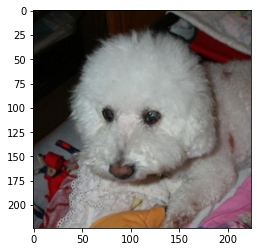

image loaded successfully!


In [10]:
# load an image in PIL format
original = Image.open(urllib.request.urlopen(train1.image[0]))
original = original.resize((imgs_model_width, imgs_model_height))
plt.imshow(original)
plt.show()
print("image loaded successfully!")

In [11]:
# convert the image to a numpy array - image is in (width, height, channel)
numpy_image = img_to_array(original)

# convert the image / images into batch format
# expand_dims will add an extra dimension to the data at a particular axis
# we want the input matrix to the network to be of the form (batchsize, height, width, channels)
# thus we add the extra dimension to the axis 0.
image_batch = np.expand_dims(numpy_image, axis=0)
print('image batch size', image_batch.shape)

# prepare the image for the VGG model
processed_image = preprocess_input(image_batch.copy())

image batch size (1, 224, 224, 3)


In [14]:
# get the extracted features
img_features = feat_extractor.predict(processed_image)
print("number of image features:",img_features.size)

number of image features: 4096


##### feed all the images into the CNN

In [15]:
len(train1.image)
train1.image[0]

'https://s3.amazonaws.com/filestore.rescuegroups.org/6918/pictures/animals/12111/12111667/60490250_500x500.jpg'

In [ ]:
# load all the images and prepare them for feeding into the CNN
importedImages = []
error=[]
file=list(train1.image).copy()

for i, f in enumerate(train1.image):
    try:
        original = Image.open(urllib.request.urlopen(f))
        original = original.resize((imgs_model_width, imgs_model_height))
        numpy_image = img_to_array(original)
        image_batch = np.expand_dims(numpy_image, axis=0)
        importedImages.append(image_batch)
    except:
        file.remove(f)
        error.append(i)
    print(i,len(importedImages),len(error))

images = np.vstack(importedImages)

processed_imgs.shape


In [ ]:
#images = np.vstack(importedImages)
processed_imgs = preprocess_input(images.copy())
processed_imgs.shape

In [6]:
error =[3800, 3821, 3846, 3880]
#len(importedImages) 
#19199

In [ ]:
#!mkdir -p models

In [16]:
#with open("models/processed_imgs.pkl", "wb") as f:
#    pkl.dump(processed_imgs, f)

with open("processed_imgs.pkl", "rb") as f:
    processed_imgs = pkl.load(f)
    
processed_imgs.shape

(19199, 224, 224, 3)

In [ ]:
len(error), len(processed_imgs), len(file)

In [7]:
train1=train1.drop(error)
print(train1.shape)
train1.head(2)

(19199, 6)


,age,image,web,name,size,sex
0,3,https://s3.amazonaws.com/filestore.rescuegroup...,https://www.aspca.org/adopt-pet/adoptable-dogs...,Candie,NaN,Female (spayed)
1,NaN,https://s3.amazonaws.com/filestore.rescuegroup...,https://www.aspca.org/adopt-pet/adoptable-dogs...,NaN,NaN,NaN


In [8]:
#train1.to_csv('train_new.csv', index=False)
train=pd.read_csv('train_new.csv')

In [9]:
# extract the images features
#imgs_features = feat_extractor.predict(processed_imgs)

#with open("models/VGG_imgs_features1.pkl", "wb") as f:
#    pkl.dump(imgs_features, f)
with open("models/VGG_imgs_features1.pkl", "rb") as f:
    imgs_features = pkl.load(f)
    
print("features successfully extracted!")
imgs_features.shape

features successfully extracted!


(19199, 4096)

### cosine distance

In [10]:
# compute cosine similarities between images

cosSimilarities = cosine_similarity(imgs_features)

# store the results into a pandas dataframe
cos_similarities_df = pd.DataFrame(cosSimilarities, columns=train.image, index=train.image)
cos_similarities_df.head()

image,https://s3.amazonaws.com/filestore.rescuegroups.org/6918/pictures/animals/12111/12111667/60490250_500x500.jpg,https://s3.amazonaws.com/filestore.rescuegroups.org/4479/pictures/animals/16429/16429542/76382106_500x375.jpg,https://s3.amazonaws.com/filestore.rescuegroups.org/4479/pictures/animals/16429/16429550/76467678_500x375.jpg,https://s3.amazonaws.com/filestore.rescuegroups.org/4479/pictures/animals/16550/16550547/77109719_500x375.jpg,https://s3.amazonaws.com/filestore.rescuegroups.org/4479/pictures/animals/16555/16555965/77219313_500x375.jpg,https://s3.amazonaws.com/filestore.rescuegroups.org/4479/pictures/animals/16556/16556506/77302182_500x375.jpg,https://s3.amazonaws.com/filestore.rescuegroups.org/4479/pictures/animals/16558/16558948/76998908_500x375.jpg,https://s3.amazonaws.com/filestore.rescuegroups.org/4479/pictures/animals/16558/16558951/77095939_500x375.jpg,https://s3.amazonaws.com/filestore.rescuegroups.org/4479/pictures/animals/16558/16558952/77219314_500x375.jpg,https://s3.amazonaws.com/filestore.rescuegroups.org/4479/pictures/animals/16579/16579328/77113531_500x375.jpg,...,https://s3.amazonaws.com/filestore.rescuegroups.org/9128/pictures/animals/16552/16552584/76995692_500x889.jpg,https://s3.amazonaws.com/filestore.rescuegroups.org/9128/pictures/animals/16262/16262015/77313126_500x666.jpg,https://s3.amazonaws.com/filestore.rescuegroups.org/9128/pictures/animals/16561/16561093/77013772_500x375.jpg,https://s3.amazonaws.com/filestore.rescuegroups.org/9128/pictures/animals/16532/16532769/76854527_500x666.jpg,https://s3.amazonaws.com/filestore.rescuegroups.org/9128/pictures/animals/16594/16594401/77201485_500x666.jpg,https://s3.amazonaws.com/filestore.rescuegroups.org/9128/pictures/animals/16594/16594402/77201487_500x666.jpg,https://s3.amazonaws.com/filestore.rescuegroups.org/8034/pictures/animals/16015/16015929/74207406_180x320.jpg,https://s3.amazonaws.com/filestore.rescuegroups.org/1976/pictures/animals/16593/16593869/77199428_500x333.jpg,https://s3.amazonaws.com/filestore.rescuegroups.org/1976/pictures/animals/16620/16620777/77328992_500x333.jpg,https://s3.amazonaws.com/filestore.rescuegroups.org/1976/pictures/animals/16621/16621712/77333044_360x480.jpg
image,,,,,,,,,,,,,,,,,,,,,
https://s3.amazonaws.com/filestore.rescuegroups.org/6918/pictures/animals/12111/12111667/60490250_500x500.jpg,1.000000,0.117397,0.103574,0.123792,0.091974,0.161709,0.071917,0.105693,0.127980,0.114384,...,0.134602,0.192012,0.248202,0.103091,0.114450,0.153346,0.129803,0.117208,0.075021,0.277589
https://s3.amazonaws.com/filestore.rescuegroups.org/4479/pictures/animals/16429/16429542/76382106_500x375.jpg,0.117397,1.000000,0.554362,0.637594,0.192266,0.358300,0.264451,0.563196,0.393322,0.415249,...,0.209876,0.273021,0.241465,0.152917,0.260044,0.411942,0.499151,0.210731,0.313051,0.148197
https://s3.amazonaws.com/filestore.rescuegroups.org/4479/pictures/animals/16429/16429550/76467678_500x375.jpg,0.103574,0.554362,1.000000,0.406076,0.301481,0.334432,0.420762,0.486047,0.457692,0.448749,...,0.201667,0.301981,0.215851,0.177937,0.267504,0.400874,0.340335,0.164006,0.424968,0.101522
https://s3.amazonaws.com/filestore.rescuegroups.org/4479/pictures/animals/16550/16550547/77109719_500x375.jpg,0.123792,0.637594,0.406076,1.000000,0.178360,0.400278,0.250251,0.567670,0.371608,0.343893,...,0.254288,0.228059,0.197700,0.156796,0.345659,0.357795,0.506256,0.277380,0.264465,0.235588
https://s3.amazonaws.com/filestore.rescuegroups.org/4479/pictures/animals/16555/16555965/77219313_500x375.jpg,0.091974,0.192266,0.301481,0.178360,1.000000,0.358243,0.414783,0.264348,0.380998,0.292001,...,0.220837,0.154436,0.134517,0.338157,0.162231,0.211155,0.197082,0.227956,0.271958,0.095648


In [11]:
train1.shape, train.shape

((19203, 7), (19199, 2))

### retrieve most similar products

In [35]:
# function to retrieve the most similar products for a given one
nb_closest_images = 11 # number of most similar images to retrieve
def retrieve_most_similar_products(given_img,imgs_features=imgs_features,num_pet=nb_closest_images):

    print("-----------------------------------------------------------------------")
    print("deal pet:")

    original = load_img(given_img, target_size=(imgs_model_width, imgs_model_height))
    plt.imshow(original)
    plt.show()
    numpy_image = img_to_array(original)
    image_batch = np.expand_dims(numpy_image, axis=0)
    processed_image = preprocess_input(image_batch.copy())
    img_feature = feat_extractor.predict(processed_image)
    imgs_features=np.concatenate((imgs_features,img_feature))

    cosSimilarities = cosine_similarity(imgs_features)
    cos_similarities_df = pd.DataFrame(cosSimilarities)
    
    print("-----------------------------------------------------------------------")
    print("most similar pet:")

    closest_imgs = cos_similarities_df.iloc[-1].sort_values(ascending=False)[1:11+1].index
    
    dict0={}
    lst=[3,2,1,0]
    for i in closest_imgs:
        age=(train1.age_new[train1.image==train.image[i]].tolist()[0])
        dict0[i]=age
    new_lst=[]
    for i in lst:
        for key,val in dict0.items():
            if val==i:
                new_lst.append(key)
    for key,val in dict0.items():
        if type(val)==float:
            new_lst.append(key)

    n=1
    for i in new_lst[0:num_pet]:
        print(train.image[i])
        index=train1.age[train1.image==train.image[i]].index.tolist()
        print('Top {}'.format(n))
        print('Name: {}'.format(train1.name[index[0]]))
        print('age: {}'.format(train1.age[index[0]]))
        print('size: {}'.format(train1['size'][index[0]]))
        print('gender: {}'.format(train1['sex'][index[0]]))
        original = Image.open(urllib.request.urlopen(train.image[i]))
        original = original.resize((imgs_model_width, imgs_model_height))
        plt.imshow(original)
        plt.show()
        n+=1

-----------------------------------------------------------------------
deal pet:


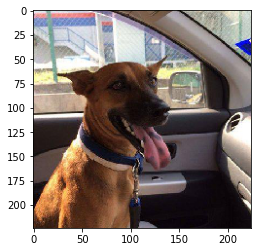

-----------------------------------------------------------------------
most similar pet:
https://s3.amazonaws.com/filestore.rescuegroups.org/8670/pictures/animals/16624/16624697/77346872_500x495.jpg
Top 1
Name: Jules
age: Senior
size: Medium
gender: Female


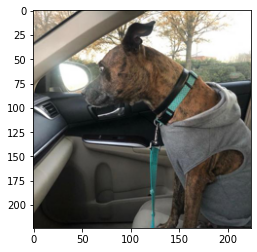

https://s3.amazonaws.com/filestore.rescuegroups.org/8787/pictures/animals/16576/16576463/77159147_500x375.jpg
Top 2
Name: Jonas
age: Senior
size: Large
gender: Male


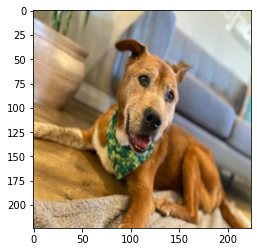

https://s3.amazonaws.com/filestore.rescuegroups.org/3055/pictures/animals/16571/16571045/77081784_360x480.jpg
Top 3
Name: DUKE
age: Senior
size: Medium
gender: Male


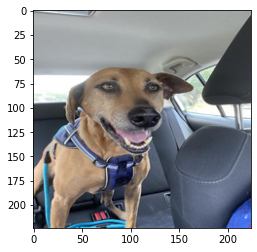

https://s3.amazonaws.com/filestore.rescuegroups.org/4468/pictures/animals/16155/16155258/76311724_500x817.jpg
Top 4
Name: Brody
age: Adult
size: X-Large
gender: Male (not neutered)


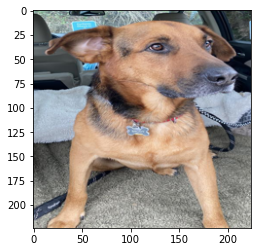

https://s3.amazonaws.com/filestore.rescuegroups.org/3781/pictures/animals/15227/15227350/77367306_359x480.jpg
Top 5
Name: Brinkmann
age: Adult
size: Medium
gender: Male (neutered)


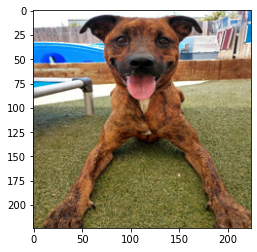

https://s3.amazonaws.com/filestore.rescuegroups.org/5089/pictures/animals/16625/16625265/77348812_480x480.jpg
Top 6
Name: Frank
age: Adult
size: Medium
gender: Male


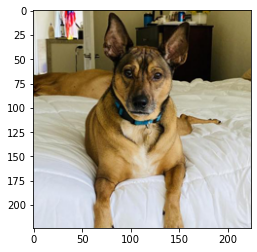

https://s3.amazonaws.com/filestore.rescuegroups.org/5089/pictures/animals/16363/16363923/76683631_480x480.jpg
Top 7
Name: Hubbard
age: Adult
size: Medium
gender: Male


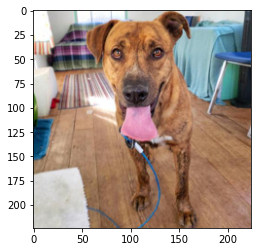

https://s3.amazonaws.com/filestore.rescuegroups.org/8980/pictures/animals/14626/14626996/67408638_500x375.jpg
Top 8
Name: Hank
age: Young
size: Large
gender: Male


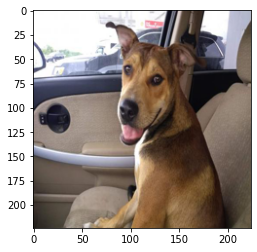

https://s3.amazonaws.com/filestore.rescuegroups.org/4909/pictures/animals/16568/16568786/77204323_500x666.jpg
Top 9
Name: Koda
age: Young
size: Large
gender: Male


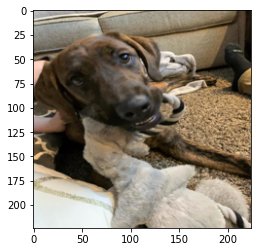

https://s3.amazonaws.com/filestore.rescuegroups.org/9454/pictures/animals/16543/16543812/76913993_500x675.jpg
Top 10
Name: BEAN
age: Baby
size: Medium
gender: Male


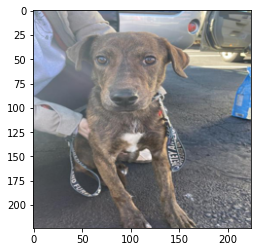

https://s3.amazonaws.com/filestore.rescuegroups.org/8670/pictures/animals/16623/16623468/77343326_500x666.jpg
Top 11
Name: nan
age: nan
size: nan
gender: nan


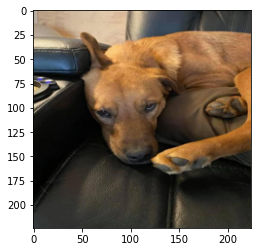

In [36]:
retrieve_most_similar_products('test_image/f4fd4fdd3-3.jpg')

### retrieve most similar products (preferentially recommend senior and adult)   

In [37]:
# function to retrieve the most similar products for a given one
nb_closest_images = 11 # number of most similar images to retrieve
def retrieve_most_similar_products1(given_img,imgs_features=imgs_features,num_pet=nb_closest_images):

    print("-----------------------------------------------------------------------")
    print("deal pet:")

    original = load_img(given_img, target_size=(imgs_model_width, imgs_model_height))
    plt.imshow(original)
    plt.show()
    numpy_image = img_to_array(original)
    image_batch = np.expand_dims(numpy_image, axis=0)
    processed_image = preprocess_input(image_batch.copy())
    img_feature = feat_extractor.predict(processed_image)
    imgs_features=np.concatenate((imgs_features,img_feature))

    cosSimilarities = cosine_similarity(imgs_features)
    cos_similarities_df = pd.DataFrame(cosSimilarities)
    
    print("-----------------------------------------------------------------------")
    print("most similar pet:")

    closest_imgs = cos_similarities_df.iloc[-1].sort_values(ascending=False)[1:11+1].index
    
    dict0={}
    lst=[3,2,1,0]
    for i in closest_imgs:
        age=(train1.age_new[train1.image==train.image[i]].tolist()[0])
        dict0[i]=age
    new_lst=[]
    for i in lst:
        for key,val in dict0.items():
            if val==i:
                new_lst.append(key)
    for key,val in dict0.items():
        if type(val)==float:
            new_lst.append(key)

    n=1
    for i in closest_imgs:
        print(train.image[i])
        index=train1.age[train1.image==train.image[i]].index.tolist()
        print('Top {}'.format(n))
        print('Name: {}'.format(train1.name[index[0]]))
        print('age: {}'.format(train1.age[index[0]]))
        print('size: {}'.format(train1['size'][index[0]]))
        print('gender: {}'.format(train1['sex'][index[0]]))
        original = Image.open(urllib.request.urlopen(train.image[i]))
        original = original.resize((imgs_model_width, imgs_model_height))
        plt.imshow(original)
        plt.show()
        n+=1

-----------------------------------------------------------------------
deal pet:


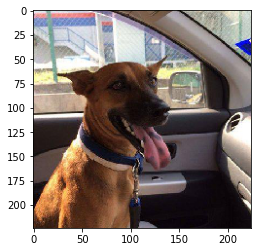

-----------------------------------------------------------------------
most similar pet:
https://s3.amazonaws.com/filestore.rescuegroups.org/4468/pictures/animals/16155/16155258/76311724_500x817.jpg
Top 1
Name: Brody
age: Adult
size: X-Large
gender: Male (not neutered)


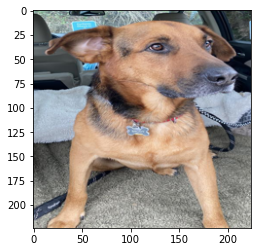

https://s3.amazonaws.com/filestore.rescuegroups.org/8670/pictures/animals/16624/16624697/77346872_500x495.jpg
Top 2
Name: Jules
age: Senior
size: Medium
gender: Female


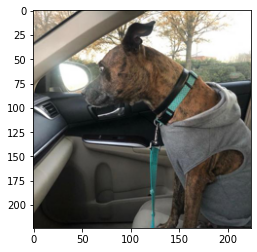

https://s3.amazonaws.com/filestore.rescuegroups.org/9454/pictures/animals/16543/16543812/76913993_500x675.jpg
Top 3
Name: BEAN
age: Baby
size: Medium
gender: Male


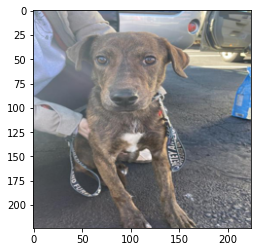

https://s3.amazonaws.com/filestore.rescuegroups.org/8980/pictures/animals/14626/14626996/67408638_500x375.jpg
Top 4
Name: Hank
age: Young
size: Large
gender: Male


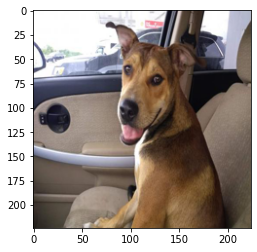

https://s3.amazonaws.com/filestore.rescuegroups.org/3781/pictures/animals/15227/15227350/77367306_359x480.jpg
Top 5
Name: Brinkmann
age: Adult
size: Medium
gender: Male (neutered)


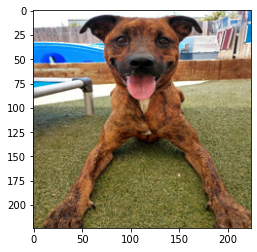

https://s3.amazonaws.com/filestore.rescuegroups.org/8670/pictures/animals/16623/16623468/77343326_500x666.jpg
Top 6
Name: nan
age: nan
size: nan
gender: nan


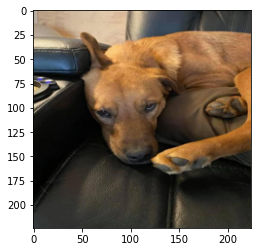

https://s3.amazonaws.com/filestore.rescuegroups.org/4909/pictures/animals/16568/16568786/77204323_500x666.jpg
Top 7
Name: Koda
age: Young
size: Large
gender: Male


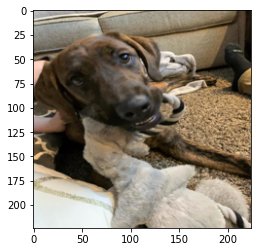

https://s3.amazonaws.com/filestore.rescuegroups.org/8787/pictures/animals/16576/16576463/77159147_500x375.jpg
Top 8
Name: Jonas
age: Senior
size: Large
gender: Male


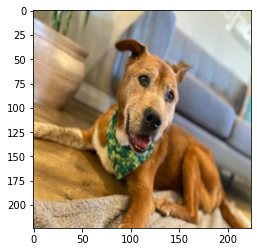

https://s3.amazonaws.com/filestore.rescuegroups.org/3055/pictures/animals/16571/16571045/77081784_360x480.jpg
Top 9
Name: DUKE
age: Senior
size: Medium
gender: Male


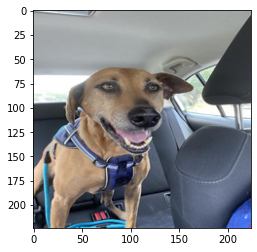

https://s3.amazonaws.com/filestore.rescuegroups.org/5089/pictures/animals/16625/16625265/77348812_480x480.jpg
Top 10
Name: Frank
age: Adult
size: Medium
gender: Male


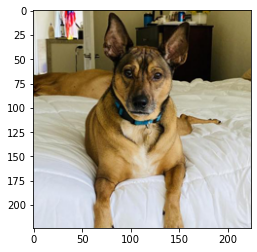

https://s3.amazonaws.com/filestore.rescuegroups.org/5089/pictures/animals/16363/16363923/76683631_480x480.jpg
Top 11
Name: Hubbard
age: Adult
size: Medium
gender: Male


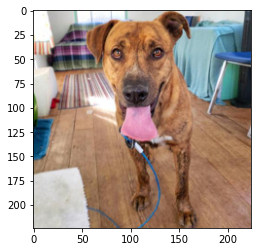

In [38]:
retrieve_most_similar_products1('test_image/f4fd4fdd3-3.jpg')